In [1]:
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
# Read data
LOCAL_DIR = os.path.join("data")
LOCAL_FILE = os.path.join(LOCAL_DIR,'housing.csv')
df = pd.read_csv(LOCAL_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Remove island homes (imbalance)
df = df[df["ocean_proximity"] != 'ISLAND']

# Create dummy variables
df = pd.get_dummies(df)

# Preview data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,1,0


In [5]:
# Median imputation
imputer = SimpleImputer(strategy = "median")
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns = df.columns)

# Preview changes
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,1.0,0.0


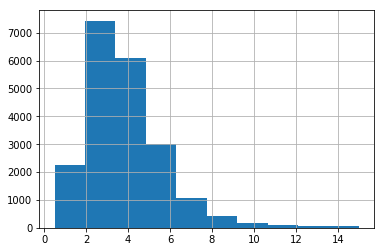

In [6]:
df['median_income'].hist()

In [7]:
# Bucketize median income to stratify test/train/valid split
buckets = np.linspace(0,16,6)
df['median_income_cats'] = pd.cut(df['median_income'], buckets)
df['median_income_cats'].value_counts() / len(df)

(3.2, 6.4]      0.495808
(0.0, 3.2]      0.419433
(6.4, 9.6]      0.068185
(9.6, 12.8]     0.012406
(12.8, 16.0]    0.004168
Name: median_income_cats, dtype: float64

In [8]:
# Test/train split
X_train, X_test = train_test_split(
    df,
    test_size = 0.2,
    stratify = df['median_income_cats'],
    shuffle = True,
    random_state = 314
)

In [9]:
# Train/validation split
X_train, X_valid = train_test_split(
    X_train,
    test_size = 0.15,
    stratify = X_train['median_income_cats'],
    shuffle = True,
    random_state = 314
)

In [10]:
# Separate X & Y
#b=df.iloc[:,1:].values
y_train = X_train.loc[:, 'median_house_value'].values
y_valid = X_valid.loc[:, 'median_house_value'].values
y_test = X_test.loc[:, 'median_house_value'].values

X_train.drop('median_house_value', axis = 1, inplace = True)
X_valid.drop('median_house_value', axis = 1, inplace = True)
X_test.drop('median_house_value', axis = 1, inplace = True)

# Remove bucketized y as well
X_train.drop('median_income_cats', axis = 1, inplace = True)
X_valid.drop('median_income_cats', axis = 1, inplace = True)
X_test.drop('median_income_cats', axis = 1, inplace = True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
# MinMax scale x
scalerMM = MinMaxScaler()
scalerMM.fit(X_train)

X_train_scaled = scalerMM.transform(X_train)
X_valid_scaled = scalerMM.transform(X_valid)
X_test_scaled = scalerMM.transform(X_test)

In [12]:
# MinMax scale y
scalerMM_y = MinMaxScaler()
scalerMM_y.fit(y_train.reshape(-1, 1))

y_train_scaled = scalerMM_y.transform(y_train.reshape(-1, 1))
y_valid_scaled = scalerMM_y.transform(y_valid.reshape(-1, 1))
y_test_scaled = scalerMM_y.transform(y_test.reshape(-1, 1))

In [16]:
rf = RandomForestRegressor(random_state = 314)
rf.fit(X_train_scaled, y_train_scaled)
print("Training set score: {:.2f}".format(rf.score(X_train_scaled, y_train_scaled)))
print("validation set score: {:.2f}".format(rf.score(X_valid_scaled, y_valid_scaled)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training set score: 0.96
validation set score: 0.78


In [17]:
gb = GradientBoostingRegressor(learning_rate = 1, random_state = 314).fit(X_train_scaled, y_train_scaled)
print("Training set score: {:.2f}".format(gb.score(X_train_scaled, y_train_scaled)))
print("validation set score: {:.2f}".format(gb.score(X_valid_scaled, y_valid_scaled)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training set score: 0.87
validation set score: 0.78


At this point, we would tune model parameters and use the testing set to measure the effectiveness of the final model